# SIADS 591 Milestone
## Causality & Mitigations - Analysis of NYC accidents

- Amit Kumar Jha (amitjha)
- Sahil Pujari (pujari)


# Table of Contents
1. [Datasets](#datasets)
2. [Required packages](#required_packages)
3. [Downloading required data](#downloading_required_data)
4. [Joining Datasets](#joining_datasets)
5. [Q1. Most common causes of traffic accidents in New York?](#q1_start)
6. [Q2. Are there any locations which are more prone to traffic accidents than others?](#q2_start)
7. [Q3. Are there any sections of society which are more prone to accidents, causal/victims like pedestrians, cyclists or bike users in specific locations?](#q3_start)
7. [Q4. Attributes of vehicles with most accidents](#q4_start)

## Datasets  <a class="anchor" id="datasets"></a>

In [1]:
HOSPITALS_HIFLD = 'Hospitals.csv'
MOTOR_VEHICLE_COLLISIONS_CRASHES = 'Motor_Vehicle_Collisions_-_Crashes.csv'
MOTOR_VEHICLE_COLLISIONS_PERSONS = 'Motor_Vehicle_Collisions_-_Person.csv'
MOTOR_VEHICLE_COLLISIONS_VEHICLES = 'Motor_Vehicle_Collisions_-_Vehicles.csv'
TRAFFIC_VOLUME_COUNTS = 'Traffic_Volume_Counts__2014-2019_.csv'
TRAFFIC_SPEEDS = 'DOT_Traffic_Speeds_NBE.csv'

datasets_and_uris = {}
datasets_and_uris[HOSPITALS_HIFLD] = 'https://opendata.arcgis.com/api/v3/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0/downloads/data?format=csv&spatialRefId=3857'
datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_CRASHES] = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_PERSONS] = 'https://data.cityofnewyork.us/api/views/f55k-p6yu/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_VEHICLES] = 'https://data.cityofnewyork.us/api/views/bm4k-52h4/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[TRAFFIC_VOLUME_COUNTS] = 'https://data.cityofnewyork.us/api/views/ertz-hr4r/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[TRAFFIC_SPEEDS] = 'https://data.cityofnewyork.us/api/views/i4gi-tjb9/rows.csv?accessType=DOWNLOAD'

## Required packages <a class="anchor" id="required_packages"></a>

In [2]:
import numpy as np
import pandas as pd
import altair as alt
import requests
import random
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import folium
from folium import plugins
import geopandas as gpd
from folium import Marker, Circle, CircleMarker, Choropleth  
from folium.plugins import MarkerCluster, HeatMap
from geopandas.tools import geocode
from shapely.geometry import Point 
plt.style.use('seaborn')

In [3]:
# Helper routines

city_geo_dict = {}
def city_geocoder(city):
    ''' geocodes the city, which we want to explore
    city - name of the city you wish to explore'''
    try:
        print(city)
        if city in city_geo_dict:
            print('getting from lookup')
            result = city_geo_dict[city]
        else:
            result = geocode(city, provider='nominatim').geometry.iloc[0]
            city_geo_dict[city] = result
        return(result)
    except:
        print('could not geocode the city')
        return None            
    
def geo_preprocessing(data):
    data = data.copy()
    geometry = [Point(float(x),float(y)) for x,y in zip(data['longitude'], data['latitude'])]
    crs = ('epsg:5179')
    data = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)
    return(data)  

## Downloading required data  <a class="anchor" id="downloading_required_data"></a>

In [4]:
def download_data(uri, path, filename):
    """
    Downloads file from a direct URL
    
    @param uri: URI of the file
    @param path: path to write the file
    @param filename: Name to give the downloaded resource
    """
    filepath = path + "/" + filename
    if os.path.isfile(filepath):
        print(filepath)
        print('file already exists, no need to download')
    else:
        result = requests.get(uri) 
        with open(filepath, 'wb') as f:
            f.write(result.content)
            
ASSETS_PATH = 'assets/datasets'

for filename, uri in datasets_and_uris.items():
    download_data(uri, ASSETS_PATH, filename)

assets/datasets/Hospitals.csv
file already exists, no need to download
assets/datasets/Motor_Vehicle_Collisions_-_Crashes.csv
file already exists, no need to download
assets/datasets/Motor_Vehicle_Collisions_-_Person.csv
file already exists, no need to download
assets/datasets/Motor_Vehicle_Collisions_-_Vehicles.csv
file already exists, no need to download
assets/datasets/Traffic_Volume_Counts__2014-2019_.csv
file already exists, no need to download
assets/datasets/DOT_Traffic_Speeds_NBE.csv
file already exists, no need to download


### Convert to dataframes and postprocess / join <a class="anchor" id="joining_datasets"></a>

In [5]:
# Crashes
mv_crashes_df = pd.read_csv(ASSETS_PATH + '/' + MOTOR_VEHICLE_COLLISIONS_CRASHES, low_memory=False)
mv_crashes_df['CRASH DATE'] = pd.to_datetime(mv_crashes_df['CRASH DATE'])
mv_crashes_df.set_index('COLLISION_ID', inplace=True)

In [6]:
# Persons
mv_persons_df = pd.read_csv(ASSETS_PATH + '/' + MOTOR_VEHICLE_COLLISIONS_PERSONS, low_memory=False)
mv_persons_df.set_index('COLLISION_ID', inplace=True)

In [7]:
# Vehicles
mv_vehicles_df = pd.read_csv(ASSETS_PATH + '/' + MOTOR_VEHICLE_COLLISIONS_VEHICLES, low_memory=False)
mv_vehicles_df.set_index('COLLISION_ID', inplace=True)

In [8]:
# Join all datasets on (COLLISION_ID)
mv_combined_df = mv_crashes_df.merge(mv_persons_df, on='COLLISION_ID', how='left')
mv_combined_df = mv_combined_df.merge(mv_vehicles_df, on='COLLISION_ID', how='left')

In [9]:
# Create a sample for 2018 for development
sample_mv_combined_df = mv_combined_df[mv_combined_df['CRASH DATE'].dt.year == 2018]

In [10]:
sample_mv_combined_df.head(4).to_dict()

{'CRASH DATE': {4027122.0: Timestamp('2018-11-14 00:00:00')},
 'CRASH TIME': {4027122.0: '13:30'},
 'BOROUGH': {4027122.0: nan},
 'ZIP CODE': {4027122.0: nan},
 'LATITUDE': {4027122.0: nan},
 'LONGITUDE': {4027122.0: nan},
 'LOCATION': {4027122.0: nan},
 'ON STREET NAME': {4027122.0: 'HENRY HUDSON PARKWAY            '},
 'CROSS STREET NAME': {4027122.0: nan},
 'OFF STREET NAME': {4027122.0: nan},
 'NUMBER OF PERSONS INJURED': {4027122.0: 0.0},
 'NUMBER OF PERSONS KILLED': {4027122.0: 0.0},
 'NUMBER OF PEDESTRIANS INJURED': {4027122.0: 0},
 'NUMBER OF PEDESTRIANS KILLED': {4027122.0: 0},
 'NUMBER OF CYCLIST INJURED': {4027122.0: 0},
 'NUMBER OF CYCLIST KILLED': {4027122.0: 0},
 'NUMBER OF MOTORIST INJURED': {4027122.0: 0},
 'NUMBER OF MOTORIST KILLED': {4027122.0: 0},
 'CONTRIBUTING FACTOR VEHICLE 1': {4027122.0: 'Following Too Closely'},
 'CONTRIBUTING FACTOR VEHICLE 2': {4027122.0: 'Unspecified'},
 'CONTRIBUTING FACTOR VEHICLE 3': {4027122.0: nan},
 'CONTRIBUTING FACTOR VEHICLE 4': {4

## Q1. Most common causes of traffic accidents in New York? <a class="anchor" id="q1_start"></a>

### Contributing Factors

In [11]:
from collections import Counter

# For the purpose of finding prominent contributing factors, we need to combine X / Y parties of the accident
contributing_factor_1_y = sample_mv_combined_df['CONTRIBUTING_FACTOR_1_y'].value_counts().to_dict()
contributing_factor_2_y = sample_mv_combined_df['CONTRIBUTING_FACTOR_2_y'].value_counts().to_dict()
# Combine with vehicle factors
cf_vehicle_1 = sample_mv_combined_df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().to_dict()
cf_vehicle_2 = sample_mv_combined_df['CONTRIBUTING FACTOR VEHICLE 2'].value_counts().to_dict()
cf_vehicle_3 = sample_mv_combined_df['CONTRIBUTING FACTOR VEHICLE 3'].value_counts().to_dict()
cf_vehicle_4 = sample_mv_combined_df['CONTRIBUTING FACTOR VEHICLE 4'].value_counts().to_dict()
cf_vehicle_5 = sample_mv_combined_df['CONTRIBUTING FACTOR VEHICLE 5'].value_counts().to_dict()
# Create a combined freq dict
cf_combined = Counter(contributing_factor_1_y) + Counter(contributing_factor_2_y) + Counter(cf_vehicle_1) + Counter(cf_vehicle_2) + Counter(cf_vehicle_3) + Counter(cf_vehicle_4) + Counter(cf_vehicle_5)
del cf_combined['Unspecified']

# Top 10 contributing factors
cf_combined.most_common(10)

[('Driver Inattention/Distraction', 484333),
 ('Following Too Closely', 222202),
 ('Failure to Yield Right-of-Way', 124127),
 ('Passing or Lane Usage Improper', 90386),
 ('Unsafe Lane Changing', 74033),
 ('Passing Too Closely', 73316),
 ('Other Vehicular', 72862),
 ('Backing Unsafely', 71767),
 ('Turning Improperly', 45840),
 ('Traffic Control Disregarded', 37355)]

### Bar Chart contributing factors

In [12]:
# Create mapping for the contributing factor strings to fit in the heatmap / future analysis
all_factors_list = cf_combined.keys()
# factors_to_int_mapping = dict([(y,x+1) for x,y in enumerate(sorted(set(all_factors_list)))])

cf_combined_df = pd.DataFrame(cf_combined.items(), columns=['Factor', 'Count'])

alt.Chart(cf_combined_df).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Factor:N', sort='-x')
)

alt.Chart(...)

### Pre-Crash Most Common Events

In [13]:
pre_crash_combined = Counter(sample_mv_combined_df['PRE_CRASH'].value_counts().to_dict())

pre_crash_combined_df = pd.DataFrame(pre_crash_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
pre_crash_combined.most_common(10)

[('Going Straight Ahead', 446540),
 ('Parked', 117386),
 ('Making Left Turn', 53697),
 ('Stopped in Traffic', 51042),
 ('Making Right Turn', 46225),
 ('Slowing or Stopping', 39591),
 ('Changing Lanes', 30142),
 ('Backing', 29954),
 ('Merging', 16141),
 ('Starting from Parking', 16132)]

In [14]:
alt.Chart(pre_crash_combined_df).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Factor:N', sort='-x')
)

alt.Chart(...)

### Most Common - Emotional Status / Bodily Injuries

In [15]:
# Emotional Status (Ignoring Conscious)
emotional_status_combined = Counter(sample_mv_combined_df['EMOTIONAL_STATUS'].value_counts().to_dict())
emotional_status_combined.pop('Does Not Apply', None)
emotional_status_combined.pop('Unknown', None)
emotional_status_combined.pop('Conscious', None)
emotional_status_combined_df = pd.DataFrame(emotional_status_combined.items(), columns=['Factor', 'Count'])
emotional_status_combined_df.set_index('Factor', inplace=True)
# Top 10 pre crash events
emotional_status_combined.most_common(10)

[('Shock', 1210),
 ('Semiconscious', 237),
 ('Apparent Death', 225),
 ('Incoherent', 171),
 ('Unconscious', 166)]

<AxesSubplot:ylabel='Count'>

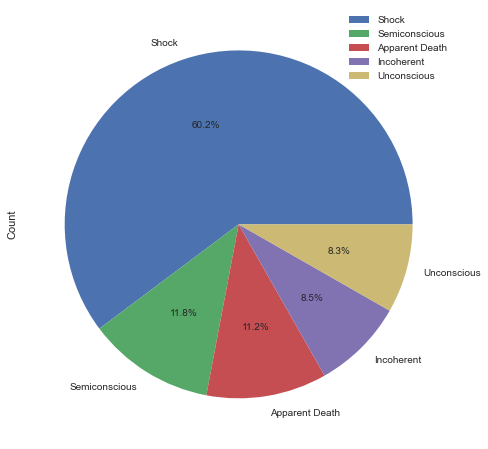

In [16]:
emotional_status_combined_df.plot.pie(x='Factor', y='Count', figsize=(8, 8), autopct='%1.1f%%')

In [17]:
# Bodily Injury
bodily_injury_combined = Counter(sample_mv_combined_df['BODILY_INJURY'].value_counts().to_dict())
bodily_injury_combined.pop('Does Not Apply', None)
bodily_injury_combined.pop('Unknown', None)
bodily_injury_combined_df = pd.DataFrame(bodily_injury_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
bodily_injury_combined.most_common(10)

[('Neck', 10620),
 ('Back', 10136),
 ('Head', 6997),
 ('Knee-Lower Leg Foot', 6223),
 ('Entire Body', 4158),
 ('Shoulder - Upper Arm', 3445),
 ('Elbow-Lower-Arm-Hand', 3076),
 ('Chest', 2289),
 ('Hip-Upper Leg', 1474),
 ('Face', 1282)]

In [18]:
alt.Chart(bodily_injury_combined_df).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Factor:N', sort='-x')
)

alt.Chart(...)

<AxesSubplot:ylabel='Count'>

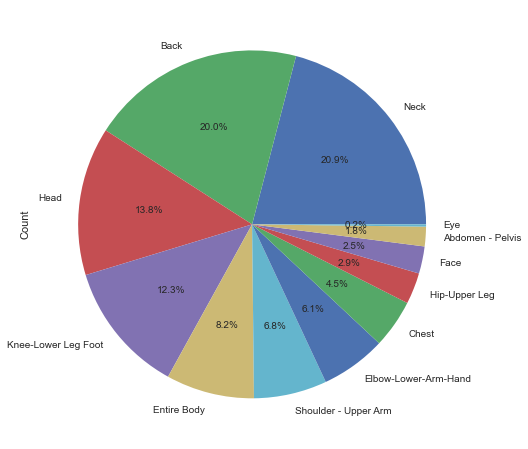

In [19]:
bodily_injury_combined_pie_df = bodily_injury_combined_df.copy()
bodily_injury_combined_pie_df.set_index('Factor', inplace=True)
bodily_injury_combined_pie_df.plot.pie(x='Factor', y='Count', figsize=(8, 8), autopct='%1.1f%%', legend=False)

### Pedestrian | Most Common - Pre-Crash Pedestrian Action

In [20]:
# What pedestrian was doing before the crash
ped_action_combined = Counter(sample_mv_combined_df['PED_ACTION'].value_counts().to_dict())
ped_action_combined.pop('Does Not Apply', None)
ped_action_combined.pop('Unknown', None)
ped_action_combined_combined_df = pd.DataFrame(ped_action_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
ped_action_combined.most_common(10)

[('Crossing With Signal', 2196),
 ('Crossing, No Signal, or Crosswalk', 994),
 ('Crossing, No Signal, Marked Crosswalk', 470),
 ('Other Actions in Roadway', 454),
 ('Crossing Against Signal', 431),
 ('Not in Roadway', 301),
 ('Emerging from in Front of/Behind Parked Vehicle', 208),
 ('Working in Roadway', 99),
 ('Getting On/Off Vehicle Other Than School Bus', 89),
 ('Riding/Walking Along Highway With Traffic', 45)]

In [21]:
alt.Chart(ped_action_combined_combined_df).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Factor:N', sort='-x')
)

alt.Chart(...)

<AxesSubplot:ylabel='Count'>

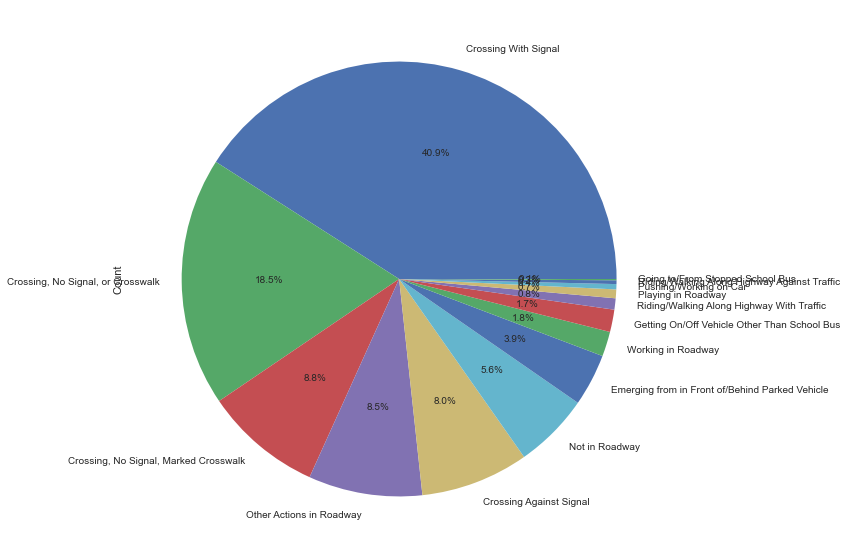

In [22]:
ped_action_combined_combined_pie_df = ped_action_combined_combined_df.copy()
ped_action_combined_combined_pie_df.set_index('Factor', inplace=True)
ped_action_combined_combined_pie_df.plot.pie(x='Factor', y='Count', figsize=(10, 10), autopct='%1.1f%%', legend=False)

### Driver | License Status - Guaging driving prowess

In [23]:
dl_status_combined = Counter(sample_mv_combined_df['DRIVER_LICENSE_STATUS'].value_counts().to_dict())
dl_status_combined.pop('Does Not Apply', None)
dl_status_combined.pop('Unknown', None)
dl_status_combined_df = pd.DataFrame(dl_status_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
dl_status_combined.most_common(10)

[('Licensed', 744164), ('Unlicensed', 10191), ('Permit', 4401)]

In [24]:
alt.Chart(dl_status_combined_df).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Factor:N', sort='-x')
)

alt.Chart(...)

<AxesSubplot:ylabel='Count'>

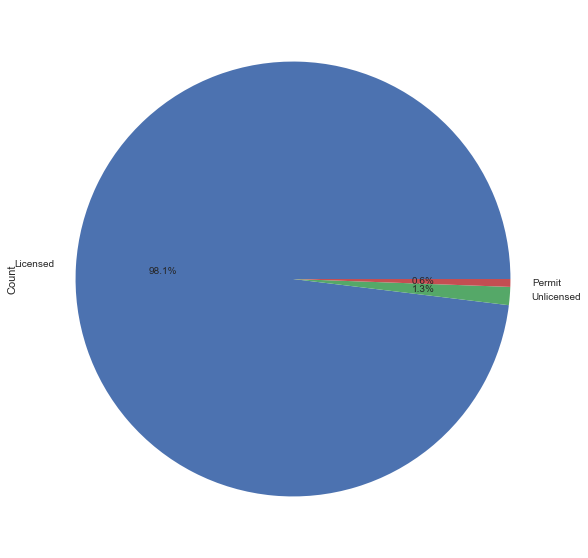

In [25]:
dl_status_combined_pie_df = dl_status_combined_df.copy()
dl_status_combined_pie_df.set_index('Factor', inplace=True)
dl_status_combined_pie_df.plot.pie(x='Factor', y='Count', figsize=(10, 10), autopct='%1.1f%%', legend=False)

### Driver | Age - Guaging driving prowess

In [26]:
dl_age_combined = Counter(sample_mv_combined_df['PERSON_AGE'].value_counts().to_dict())
dl_age_combined.pop(0.0, None)

dl_age_clean = Counter({})

for key, value in dl_age_combined.items():
    if key >= 10 and key <= 100:
        dl_age_clean[key] = value

dl_age_combined = dl_age_clean

# Create bins of 5 year range
dl_age_combined_df_raw = pd.DataFrame(dl_age_combined.items(), columns=['Factor', 'Count'])
dl_age_combined_df = dl_age_combined_df_raw.copy()
dl_age_combined_df['age_bin'] = pd.qcut(dl_age_combined_df['Factor'], q=20)
dl_age_combined_df['age_range'] = dl_age_combined_df.apply(lambda row: str(row.age_bin.left) + '-' + str(row.age_bin.right), axis=1)
dl_age_combined_df['age_range'] = dl_age_combined_df['age_range'].astype(str)
dl_age_combined_df = dl_age_combined_df.drop('age_bin', 1)
# Top 10 pre crash events
(dl_age_combined_df.groupby(['age_range'], sort=False)['Count'].sum()).nlargest(10)

age_range
23.5-28.0    79256
32.5-37.0    72461
28.0-32.5    65483
41.5-46.0    59587
50.5-55.0    57475
37.0-41.5    52941
46.0-50.5    48071
19.0-23.5    42334
55.0-59.5    39577
59.5-64.0    38889
Name: Count, dtype: int64

In [27]:
alt.Chart(dl_age_combined_df).mark_bar().encode(
    x='sum(Count)',
    y=alt.Y('age_range:N',sort='-x')
)

alt.Chart(...)

## Q2. Are there any locations which are more prone to traffic accidents than others? <a class="anchor" id="q2_start"></a>

### Pedestrian | Location:  Location of pedestrian at time of accident

In [28]:
ped_loc_combined = Counter(sample_mv_combined_df['PED_LOCATION'].value_counts().to_dict())
ped_loc_combined.pop('Does Not Apply', None)
ped_loc_combined.pop('Unknown', None)
ped_loc_combined_df = pd.DataFrame(ped_loc_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
ped_loc_combined.most_common(10)

[('Pedestrian/Bicyclist/Other Pedestrian at Intersection', 3543),
 ('Pedestrian/Bicyclist/Other Pedestrian Not at Intersection', 1921)]

<AxesSubplot:ylabel='Count'>

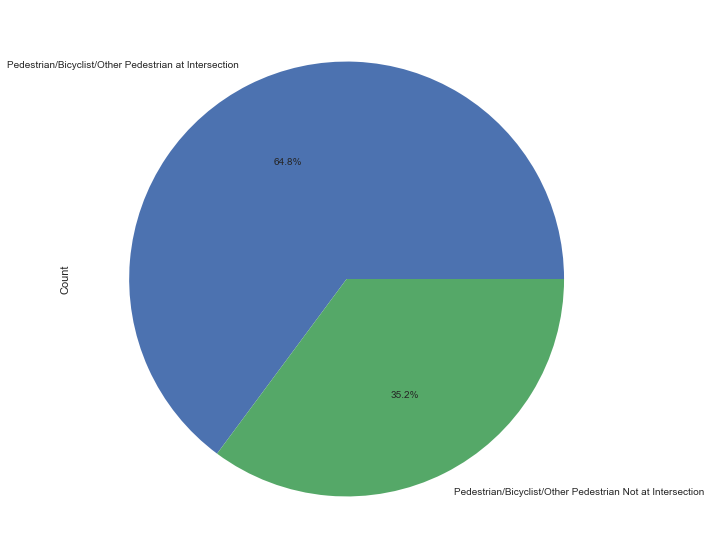

In [29]:
ped_loc_combined_pie_df = ped_loc_combined_df.copy()
ped_loc_combined_pie_df.set_index('Factor', inplace=True)
ped_loc_combined_pie_df.plot.pie(x='Factor', y='Count', figsize=(10, 10), autopct='%1.1f%%', legend=False)

### Street | Location:  Street with most crashes

In [30]:
street_loc_combined = Counter(sample_mv_combined_df['ON STREET NAME'].value_counts().to_dict())
street_loc_combined.pop('Does Not Apply', None)
street_loc_combined.pop('Unknown', None)
street_loc_combined_df = pd.DataFrame(street_loc_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
street_loc_combined.most_common(10)

[('BELT PARKWAY                    ', 16378),
 ('LONG ISLAND EXPRESSWAY          ', 12146),
 ('BROOKLYN QUEENS EXPRESSWAY      ', 11231),
 ('GRAND CENTRAL PKWY              ', 9647),
 ('FDR DRIVE                       ', 8821),
 ('ATLANTIC AVENUE                 ', 7911),
 ('BROADWAY                        ', 7556),
 ('CROSS BRONX EXPY                ', 7240),
 ('3 AVENUE                        ', 6818),
 ('CROSS ISLAND PARKWAY            ', 6741)]

In [31]:
alt.Chart(street_loc_combined_df.nlargest(25, 'Count')).mark_bar().encode(
    x='sum(Count)',
    y=alt.Y('Factor:N',sort='-x')
)

alt.Chart(...)

### Borough | Location:  Boroughs with most crashes

In [32]:
borough_loc_combined = Counter(sample_mv_combined_df['BOROUGH'].value_counts().to_dict())
borough_loc_combined.pop('Does Not Apply', None)
borough_loc_combined.pop('Unknown', None)
borough_loc_combined_df = pd.DataFrame(borough_loc_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
borough_loc_combined.most_common(10)

[('BROOKLYN', 180720),
 ('QUEENS', 155947),
 ('MANHATTAN', 114898),
 ('BRONX', 87707),
 ('STATEN ISLAND', 23898)]

<AxesSubplot:ylabel='Count'>

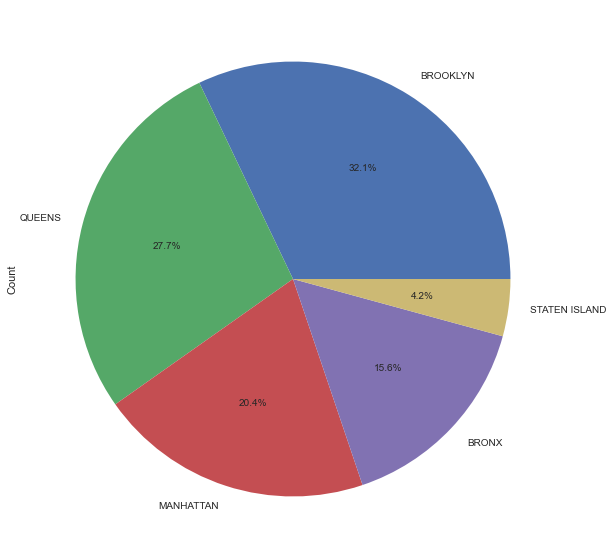

In [33]:
borough_loc_combined_pie_df = borough_loc_combined_df.copy()
borough_loc_combined_pie_df.set_index('Factor', inplace=True)
borough_loc_combined_pie_df.plot.pie(x='Factor', y='Count', figsize=(10, 10), autopct='%1.1f%%', legend=False)

### New York | Location:  Crashes across all of New York

In [48]:
# Commenting for file size

# new_york = city_geocoder('New York')
# m_1 = folium.Map(location=[new_york.y, new_york.x], tiles='OpenStreetMap', zoom_start=10)

# lat_long_df = sample_mv_combined_df[sample_mv_combined_df['LATITUDE'].notnull()]

# mc = MarkerCluster()
# for idx, row in lat_long_df.iterrows():
#     mc.add_child(Marker([row['LATITUDE'], row['LONGITUDE']]))

# m_1.add_child(mc)

## Q3. Are there any sections of society which are more prone to accidents, causal/victims like pedestrians, cyclists or bike users in specific locations?
 <a class="anchor" id="q3_start"></a>

### Injury | Comparison:  Comparing injury count of different victims

In [35]:
injury_persons_combined = Counter(sample_mv_combined_df['NUMBER OF PERSONS INJURED'].value_counts().to_dict())
injury_pedestrians_combined = Counter(sample_mv_combined_df['NUMBER OF PEDESTRIANS INJURED'].value_counts().to_dict())
injury_cyclists_combined = Counter(sample_mv_combined_df['NUMBER OF CYCLIST INJURED'].value_counts().to_dict())
injury_motorists_combined = Counter(sample_mv_combined_df['NUMBER OF MOTORIST INJURED'].value_counts().to_dict())

injury_comparison_combined_df = pd.DataFrame(injury_persons_combined.items(), columns=['Category', 'Count'])
injury_comparison_combined_df['Victim'] = 'Persons'
df  = pd.DataFrame(injury_pedestrians_combined.items(), columns=['Category', 'Count'])
df['Victim'] = 'Pedestrians'
injury_comparison_combined_df = pd.concat([injury_comparison_combined_df, df], axis =0).reset_index(drop=True)

df  = pd.DataFrame(injury_cyclists_combined.items(), columns=['Category', 'Count'])
df['Victim'] = 'Cyclist'
injury_comparison_combined_df = pd.concat([injury_comparison_combined_df, df], axis =0).reset_index(drop=True)

df  = pd.DataFrame(injury_motorists_combined.items(), columns=['Category', 'Count'])
df['Victim'] = 'Motorist'
injury_comparison_combined_df = pd.concat([injury_comparison_combined_df, df], axis =0).reset_index(drop=True)
injury_comparison_combined_df = injury_comparison_combined_df[injury_comparison_combined_df.Category != 0.0]
injury_comparison_combined_df

,Category,Count,Victim
1,1.0,128479,Persons
2,2.0,39484,Persons
3,3.0,15930,Persons
4,4.0,7497,Persons
5,5.0,3620,Persons
6,6.0,1397,Persons
7,7.0,802,Persons
8,8.0,256,Persons
9,9.0,137,Persons
10,16.0,108,Persons


In [36]:
all_vals_category = injury_comparison_combined_df['Category'].unique()

charts = []

for val in all_vals_category:
    chart = alt.Chart(injury_comparison_combined_df[injury_comparison_combined_df['Category'] == val]).mark_bar().encode(
        x='Victim:O',
        y='sum(Count):Q',
        color='Victim:N',
        column='Category:N'
    )

    chart.display()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

## Q4. Attributes of vehicles with most accidents <a class="anchor" id="q4_start"></a>

### Vehicle | Type:  Comparing crashes by vehicle types

In [37]:
vehicle_types_combined = Counter(sample_mv_combined_df['VEHICLE_TYPE'].value_counts().to_dict())
vehicle_types_combined.pop('Does Not Apply', None)
vehicle_types_combined.pop('Unknown', None)
vehicle_types_combined_df = pd.DataFrame(vehicle_types_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
vehicle_types_combined.most_common(10)

[('Sedan', 396927),
 ('Station Wagon/Sport Utility Vehicle', 317809),
 ('Taxi', 43815),
 ('Pick-up Truck', 27956),
 ('Box Truck', 18856),
 ('Bus', 18220),
 ('Bike', 9482),
 ('Tractor Truck Diesel', 7155),
 ('Van', 6098),
 ('Motorcycle', 3756)]

In [38]:
alt.Chart(vehicle_types_combined_df.nlargest(10, 'Count')).mark_bar().encode(
    x='sum(Count)',
    y=alt.Y('Factor:N',sort='-x')
)

alt.Chart(...)

### Vehicle | Makes:  Comparing crashes by vehicle makes

In [39]:
vehicle_makes_combined = Counter(sample_mv_combined_df['VEHICLE_MAKE'].value_counts().to_dict())
vehicle_makes_combined.pop('Does Not Apply', None)
vehicle_makes_combined.pop('Unknown', None)
vehicle_makes_combined_df = pd.DataFrame(vehicle_makes_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
vehicle_makes_combined.most_common(10)

[('TOYT -CAR/SUV', 156536),
 ('HOND -CAR/SUV', 104890),
 ('NISS -CAR/SUV', 89058),
 ('FORD -CAR/SUV', 73373),
 ('CHEV -CAR/SUV', 41425),
 ('HYUN -CAR/SUV', 30894),
 ('MERZ -CAR/SUV', 27034),
 ('JEEP -CAR/SUV', 26577),
 ('BMW -CAR/SUV', 24705),
 ('DODG -CAR/SUV', 21875)]

In [40]:
alt.Chart(vehicle_makes_combined_df.nlargest(20, 'Count')).mark_bar().encode(
    x='sum(Count)',
    y=alt.Y('Factor:N',sort='-x')
)

alt.Chart(...)

### Vehicle Market Share | Makes:  Comparing market share of vehicle makes in the dataset

In [42]:
all_vehicle_count = vehicle_year_combined_df['Count'].sum()
vehicle_makes_combined_df['vehicle_share'] = vehicle_makes_combined_df.apply(lambda row: (row.Count / all_vehicle_count) * 100, axis=1)

vehicle_makes_combined.nlargest(10, 'vehicle_share')

NameError: name 'vehicle_year_combined_df' is not defined

### Vehicle | Year:  Comparing crashes by vehicle year

In [43]:
vehicle_year_combined = Counter(sample_mv_combined_df['VEHICLE_YEAR'].value_counts().to_dict())
vehicle_year_combined.pop('Does Not Apply', None)
vehicle_year_combined.pop('Unknown', None)
vehicle_year_combined_df = pd.DataFrame(vehicle_year_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
vehicle_year_combined.most_common(10)

[(2017.0, 107605),
 (2016.0, 96449),
 (2015.0, 85042),
 (2018.0, 64721),
 (2014.0, 62403),
 (2013.0, 52973),
 (2012.0, 42296),
 (2011.0, 37987),
 (2007.0, 34843),
 (2008.0, 33622)]

In [44]:
alt.Chart(vehicle_year_combined_df.nlargest(20, 'Count')).mark_bar().encode(
    x='sum(Count)',
    y=alt.Y('Factor:N',sort='-x')
)

alt.Chart(...)

### Vehicle Market Share | Year:  Comparing market share of vehicle years in the dataset

In [45]:
all_vehicle_count = vehicle_year_combined_df['Count'].sum()
vehicle_year_combined_df['vehicle_share'] = vehicle_year_combined_df.apply(lambda row: (row.Count / all_vehicle_count) * 100, axis=1)

vehicle_year_combined_df.nlargest(10, 'vehicle_share')

,Factor,Count,vehicle_share
0,2017.0,107605,12.637274
1,2016.0,96449,11.327099
2,2015.0,85042,9.987446
3,2018.0,64721,7.600920
4,2014.0,62403,7.328691
5,2013.0,52973,6.221220
6,2012.0,42296,4.967298
7,2011.0,37987,4.461244
8,2007.0,34843,4.092008
9,2008.0,33622,3.948612


### Vehicle | Make & Year:  Comparing crashes by vehicle make and year

In [46]:
vehicle_make_year_raw_df = sample_mv_combined_df.copy()
vehicle_make_year_raw_df.dropna(subset=['VEHICLE_MAKE'], inplace=True)
vehicle_make_year_raw_df.dropna(subset=['VEHICLE_YEAR'], inplace=True)

vehicle_make_year_raw_df['VEHICLE_MAKE_YEAR'] = vehicle_make_year_raw_df.apply(lambda row: str(row['VEHICLE_MAKE']) + ' | ' + str(row['VEHICLE_YEAR']), axis=1)

vehicle_make_year_combined = Counter(vehicle_make_year_raw_df['VEHICLE_MAKE_YEAR'].value_counts().to_dict())
vehicle_make_year_combined.pop('Does Not Apply', None)
vehicle_make_year_combined.pop('Unknown', None)
vehicle_make_year_combined_df = pd.DataFrame(vehicle_make_year_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
vehicle_make_year_combined.most_common(15)

[('TOYT -CAR/SUV | 2015.0', 22607),
 ('TOYT -CAR/SUV | 2017.0', 19279),
 ('TOYT -CAR/SUV | 2016.0', 18968),
 ('TOYT -CAR/SUV | 2014.0', 16274),
 ('HOND -CAR/SUV | 2017.0', 13486),
 ('HOND -CAR/SUV | 2016.0', 12636),
 ('NISS -CAR/SUV | 2017.0', 12418),
 ('NISS -CAR/SUV | 2016.0', 11826),
 ('TOYT -CAR/SUV | 2013.0', 10542),
 ('TOYT -CAR/SUV | 2018.0', 10129),
 ('NISS -CAR/SUV | 2015.0', 9913),
 ('FORD -CAR/SUV | 2017.0', 9067),
 ('HOND -CAR/SUV | 2015.0', 8274),
 ('HOND -CAR/SUV | 2018.0', 8239),
 ('TOYT -CAR/SUV | 2012.0', 8069)]

### Vehicle Market Share | Make & Year:  Comparing market share of vehicle make and year combinations in the dataset

In [47]:
all_vehicle_count = vehicle_make_year_combined_df['Count'].sum()
vehicle_make_year_combined_df['vehicle_share'] = vehicle_make_year_combined_df.apply(lambda row: (row.Count / all_vehicle_count) * 100, axis=1)

vehicle_make_year_combined_df.nlargest(10, 'vehicle_share')

,Factor,Count,vehicle_share
0,TOYT -CAR/SUV | 2015.0,22607,2.685928
1,TOYT -CAR/SUV | 2017.0,19279,2.290530
2,TOYT -CAR/SUV | 2016.0,18968,2.253580
3,TOYT -CAR/SUV | 2014.0,16274,1.933507
4,HOND -CAR/SUV | 2017.0,13486,1.602266
5,HOND -CAR/SUV | 2016.0,12636,1.501278
6,NISS -CAR/SUV | 2017.0,12418,1.475377
7,NISS -CAR/SUV | 2016.0,11826,1.405042
8,TOYT -CAR/SUV | 2013.0,10542,1.252491
9,TOYT -CAR/SUV | 2018.0,10129,1.203422
